# Coral Triangle Marine Protected Areas - Data Analysis Codebook

Author: Tiffany Lam

Date: 07/01/2026

## Project Overview:
This codebook analyzes marine conservation efforts across the Coral Triangle region (Indonesia, Philippines, Malaysia, Papua New Guinea, Timor-Leste, and Solomon Islands). It processes spatial and temporal data to create visualizations examining MPA effectiveness, growth patterns, and governance.

## Outputs:
This analysis produces data for 5 main visualizations:
1. Geographic distribution map (choropleth with temporal slider)
2. Temporal growth trends (line chart with global benchmark)
3. Progress towards 2030 targets (regression projections)
4. MPA strategy clusters (scatter plot with k-means clustering)
5. Governance structures (stacked bar chart)

## How to Use this Codebook:
1. Update file paths in "Configuration" section to match your setup
2. Download required datasets (links provided in "Data Sources" section)
3. Run cells sequentially from top to bottom
4. Data exports automatically to specified output directory
5. All charts use standardized naming convention: chart[N]_description

## Requirements:
- Python 3.x
- Required packages: pandas, geopandas, os, requests, json, numpy, scipy, sklearn, matplotlib, seaborn

## Replication Notes:
- All data sources are publicly available
- Analysis uses fixed random-state for reproducibility
- File paths are clearly marked for easy modification
- Intermediate outputs are preserved for verification

## Section 1: Library Imports

In [1]:
# Import Libraries
import pandas as pd
import geopandas as gpd
import os
import requests
import json
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## Section 2: Configuration

Modify these paths to match your local setup

In [2]:
# Define six Coral Triangle countries
# Format {ISO3 code: Full country name}
ct = {
    'IDN': 'Indonesia', 
    'PHL': 'Philippines', 
    'MYS': 'Malaysia', 
    'PNG': 'Papua New Guinea', 
    'TLS': 'Timor-Leste', 
    'SLB': 'Solomon Islands'
}

# Input directory: Where you've saved downloaded datasets
down_path = '/Users/tiffanylam/Desktop/LSE/Year 2/PP434 Automated Data Visualization for Policymaking/Project/Data/'

# Output directory: Where processed files will be saved
up_path = '/Users/tiffanylam/Desktop/LSE/Year 2/PP434 Automated Data Visualization for Policymaking/tiffanylam18.github.io/PP434_project/data/'

## Section 3: Data Sources & Download Instructions

Download the following datasets and save to down_path:

1. World Database on Protected Areas (WDPA)
   
   Source: https://www.protectedplanet.net/en/thematic-areas/marine-protected-areas
   
   Files needed: WDPA_Nov2025_Public_shp.zip (extract all 3 parts)
   
   Description: Global database of marine and terrestrial protected areas

2. Marine Exclusive Economic Zones (EEZ)
   
   Source: https://www.marineregions.org/downloads.php
   
   Files needed: EEZ_land_union_v4_202410.shp
   
   Description: Maritime boundaries of world countries

3. Global Protection Coverage Data
   
   Source: https://digitalreport.protectedplanet.net/?chapter=3
   
   File needed: global_wdpa_wdoecm_coverage_2000_2024.csv
   
   Description: Time series of global marine protection coverage

Automation Note:
This analysis does not use APIs or web scraping. Marine protection data is updated infrequently (annual updates).

### Data Loading - Marine Protected Areas

In [3]:
# Initialize empty list to store shapefile parts
gdf_parts = []

# Load three World Database on Protected Areas (WDPA) polygon shapefiles
for i in range(3):
    gdf = gpd.read_file(
        f'{down_path}WDPA_Nov2025_Public_shp_{i}/WDPA_Nov2025_Public_shp-polygons.shp')
    
    # Add filters
    ct_part = gdf[
        # Filter for coral triangle countries
        (gdf['PRNT_ISO3'].isin(ct)) &
        # Filter for marine/coastal areas
        (gdf['REALM'].str.contains('Marine|Coastal', case=False)) &
        # Filter for non-zero marine areas
        (gdf['REP_M_AREA'] > 0) & 
        # Filter for valid establishment years
        (gdf['STATUS_YR'] > 0) &
        (gdf['STATUS_YR']  <= 2025)
    ]
    
    gdf_parts.append(ct_part)

# Merge all three parts into single GeoDataFrame
ct_wdpa_gdf = pd.concat(gdf_parts, ignore_index=True)

# De-duplicate MPAs (keeps largest area if duplicates exist)
ct_wdpa_gdf = ct_wdpa_gdf.sort_values('REP_M_AREA', ascending=False)
ct_wdpa_gdf = ct_wdpa_gdf.drop_duplicates(subset='SITE_ID', keep='first')

# Drop unnecessary columns
ct_wdpa_gdf.drop(['SITE_TYPE', 'NAME', 'DESIG', 'GOVSUBTYPE', 'OWNSUBTYPE', 'METADATAID', 'ISO3', 'SUPP_INFO', 'CONS_OBJ', 'INLND_WTRS', 'OECM_ASMT'], axis=1, inplace=True)

# Filter for operational MPAs
op_status = ['Inscribed', 'Designated', 'Established']
ct_wdpa_op_gdf = ct_wdpa_gdf[ct_wdpa_gdf['STATUS'].isin(op_status)]

ct_wdpa_op_gdf

,SITE_ID,SITE_PID,NAME_ENG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,REALM,REP_M_AREA,GIS_M_AREA,...,NO_TK_AREA,STATUS,STATUS_YR,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,PRNT_ISO3,geometry
137,555721606,555721606,Luconia Shoals National Park,National Park,National,Not Reported,Not Applicable,Marine,10117.720,10100.791045,...,0.000,Established,2019,Sub-national ministry or agency,Not Reported,Sarawak Forestry Corporation (SFC),Not Reported,State Verified,MYS,"POLYGON ((112.96400 4.80203, 112.64354 4.74868..."
66,555511958,555511958,Kaimana,Locally Managed Marine Area,National,VI,Not Applicable,Marine,5977.470,5027.161455,...,0.000,Designated,2008,Sub-national ministry or agency,Not Reported,District/Local Government assisted by Ministry...,Not Reported,State Verified,IDN,"POLYGON ((133.79944 -2.90694, 133.80111 -2.908..."
53,306476,306476,Tañon Strait Protected Seascape,Protected Seascape,National,V,Not Applicable,Marine,5302.540,5286.175592,...,0.000,Designated,2018,Federal or national ministry or agency,State,Protected Area Management Board,https://drive.google.com/drive/folders/1cJsdmo...,State Verified,PHL,"POLYGON ((123.99681 11.26740, 123.99568 11.265..."
136,555715065,555715065,Tubbataha Reefs Natural Park,ASEAN Heritage Park,Regional,II,Not Applicable,Marine,4515.980,4506.158859,...,4515.980,Designated,2015,Federal or national ministry or agency,State,Protected Area Management Board,https://drive.google.com/drive/folders/1J4vx8C...,State Verified,PHL,"POLYGON ((120.23317 8.82720, 119.88595 8.49389..."
135,555715057,555715057,Ticao-Burias Pass Protected Seascape,Protected Seascape,National,V,Not Applicable,Marine,3913.830,3867.025800,...,0.000,Designated,2018,Federal or national ministry or agency,State,Protected Area Management Board,https://drive.google.com/drive/folders/1WA1uFz...,State Verified,PHL,"POLYGON ((123.30163 13.14737, 123.29987 13.124..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,198406,198406,Pulau Ekor Tebu Marine Park,Marine Park,National,II,Not Applicable,Marine,0.100,41.118553,...,0.100,Designated,1994,Federal or national ministry or agency,State,Department of Fisheries (DOF),Not Reported,State Verified,MYS,"POLYGON ((103.05434 5.76406, 103.05541 5.76297..."
96,555547886,555547886,Hot Spot Reef,Marine Managed Area,Not Applicable,Not Assigned,Not Applicable,Marine,0.051,0.048452,...,0.051,Established,1998,Not Reported,Not Reported,Not Reported,Not Reported,State Verified,SLB,"POLYGON ((156.81633 -8.03069, 156.81722 -8.029..."
50,306443,306443,Naro Island Wildlife Sanctuary,Wildlife Sanctuary,National,IV,Not Applicable,Coastal,0.030,0.534862,...,0.000,Designated,2000,Federal or national ministry or agency,State,Protected Area Management Board,https://drive.google.com/drive/folders/1_ZeAUw...,State Verified,PHL,"POLYGON ((123.66109 11.90248, 123.66115 11.902..."
101,555547900,555547900,Whal Island,Locally Managed Marine Area,National,Not Reported,Not Applicable,Coastal,0.022,0.033375,...,0.022,Designated,1997,Indigenous Peoples,Not Reported,Not Reported,Not Reported,State Verified,PNG,"POLYGON ((146.83187 -2.26821, 146.83150 -2.268..."


### Data Loading - Exclusive Economic Zones

In [4]:
# Read country Exclusive Economic Zones (EEZ) shapefile
eez_df = gpd.read_file(f'{down_path}EEZ_land_union_v4_202410.shp')

# Filter for Coral Triangle countries and EEZ area type
ct_eez_df = eez_df.query('(ISO_SOV1 in @ct.keys()) and (POL_TYPE == "Union EEZ and country")')

# Drop unnecessary columns
eez_cols = ['UNION', 'ISO_SOV1', 'POL_TYPE', 'Y_1', 'x_1', 'AREA_KM2', 'geometry']
ct_eez_df = ct_eez_df[eez_cols]

# Dissolve EEZ polygons per country
ct_eez_diss_df = ct_eez_df.dissolve(by='ISO_SOV1', aggfunc='sum').reset_index()
ct_eez_diss_df

# Aggregate EEZ area per country
ct_eez_area_df = ct_eez_df.groupby('ISO_SOV1')['AREA_KM2'].sum()
ct_eez_area_df

ISO_SOV1
IDN    7906619
MYS     847078
PHL    2260601
PNG    2861551
SLB    1631261
TLS      92238
Name: AREA_KM2, dtype: int64

## Section 4: Visualizations & Analysis

### Chart 2: Growth of Marine Protected Areas
- Type: Multi-line chart with global benchmark comparison
- Data sources: WDPA, Protected Planet Reports
- Shows: Cumulative protected area over time, compared to global average
- Interactivity: Year slider to explore temporal progression, hover to highlight individual country trajectories
- Key insight: When did protection accelerate? Do countries show recent momentum or stagnation relative to global trends?
- Purpose: Identify temporal commitment patterns and comparative growth rates

In [5]:
# Aggregate protected area by country and year
ct_yrly_totals = ct_wdpa_op_gdf.groupby(['PRNT_ISO3', 'STATUS_YR'])['REP_M_AREA'].sum().reset_index()

# Calculate cumulative MPA area and count for each country
ct_cum = []
for country in ct:
    ct_df = ct_yrly_totals[ct_yrly_totals['PRNT_ISO3'] == country].sort_values('STATUS_YR').copy()
    ct_df['cumulative_area'] = ct_df['REP_M_AREA'].cumsum()
    ct_df['num_mpas'] = range(1, len(ct_df) + 1)
    ct_cum.append(ct_df)
ct_cum_df = pd.concat(ct_cum, ignore_index=True)

# Map country name and EEZ area
ct_cum_df['country_name'] = ct_cum_df['PRNT_ISO3'].map(ct)
ct_cum_df['eez_km2'] = ct_cum_df['PRNT_ISO3'].map(ct_eez_area_df)

# Calculate protection rate percentage
ct_cum_df['protection_rate_pct'] = ct_cum_df['cumulative_area'] / ct_cum_df['eez_km2'] * 100

# Add region label
ct_cum_df['region'] = 'Coral Triangle'
ct_cum_df

,PRNT_ISO3,STATUS_YR,REP_M_AREA,cumulative_area,num_mpas,country_name,eez_km2,protection_rate_pct,region
0,IDN,1977,1520.000000,1520.000000,1,Indonesia,7906619,0.019224,Coral Triangle
1,IDN,1982,665.600000,2185.600000,2,Indonesia,7906619,0.027643,Coral Triangle
2,IDN,1991,3981.250000,6166.850000,3,Indonesia,7906619,0.077996,Coral Triangle
3,IDN,1999,110.000000,6276.850000,4,Indonesia,7906619,0.079387,Coral Triangle
4,IDN,2001,1101.173000,7378.023000,5,Indonesia,7906619,0.093315,Coral Triangle
5,IDN,2003,360.000000,7738.023000,6,Indonesia,7906619,0.097868,Coral Triangle
6,IDN,2005,220.990000,7959.013000,7,Indonesia,7906619,0.100663,Coral Triangle
7,IDN,2006,115.258900,8074.271900,8,Indonesia,7906619,0.102120,Coral Triangle
8,IDN,2007,1618.460000,9692.731900,9,Indonesia,7906619,0.122590,Coral Triangle
9,IDN,2008,5977.470000,15670.201900,10,Indonesia,7906619,0.198191,Coral Triangle


In [6]:
# Read Global Protected Area file
global_wdpa = pd.read_csv(f'{down_path}global_wdpa_wdoecm_coverage_2000_2024.csv')

# Drop unnecessary column
global_wdpa.drop('terrestrial_pca_coverage_km2', axis=1, inplace=True)

# Calculate protected percentage, dividing by total ocean area
global_wdpa['marine_protected_pct'] = global_wdpa['marine_pca_coverage_km2']/361000000 * 100

# Rename columns to match ct cumulative df
global_wdpa.rename(columns={
    'year': 'STATUS_YR',
    'marine_pca_coverage_km2': 'cumulative_area',
    'marine_protected_pct': 'protection_rate_pct'
}, inplace=True)

# Add country_name and region labels
global_wdpa['country_name'] = 'Global Average'
global_wdpa['region'] = 'Global'

# Combine global and cumulative df
ct_cum_df = pd.concat([ct_cum_df, global_wdpa], ignore_index=True)

# Sort for cleanliness
ct_cum_df = ct_cum_df.sort_values(['region', 'country_name', 'STATUS_YR'])
ct_cum_df

,PRNT_ISO3,STATUS_YR,REP_M_AREA,cumulative_area,num_mpas,country_name,eez_km2,protection_rate_pct,region
0,IDN,1977,1520.000,1.520000e+03,1.0,Indonesia,7906619.0,0.019224,Coral Triangle
1,IDN,1982,665.600,2.185600e+03,2.0,Indonesia,7906619.0,0.027643,Coral Triangle
2,IDN,1991,3981.250,6.166850e+03,3.0,Indonesia,7906619.0,0.077996,Coral Triangle
3,IDN,1999,110.000,6.276850e+03,4.0,Indonesia,7906619.0,0.079387,Coral Triangle
4,IDN,2001,1101.173,7.378023e+03,5.0,Indonesia,7906619.0,0.093315,Coral Triangle
...,...,...,...,...,...,...,...,...,...
63,NaN,2020,NaN,2.887585e+07,NaN,Global Average,NaN,7.998850,Global
64,NaN,2021,NaN,2.899847e+07,NaN,Global Average,NaN,8.032816,Global
65,NaN,2022,NaN,3.007143e+07,NaN,Global Average,NaN,8.330036,Global
66,NaN,2023,NaN,3.063901e+07,NaN,Global Average,NaN,8.487262,Global


### Chart 1: Geographic Distribution of Marine Protection
- Type: Interactive choropleth map with year slider
- Data sources: WDPA, Marine Regions EEZ boundaries
- Shows: Protection coverage (% of EEZ) by country
- Interactivity: Year slider enables temporal exploration of MPA establishment patterns
- Key insight: Which countries lead or lag in marine protection?
- Purpose: Establish geographic context and identify regional leaders/laggards

In [7]:
# Merge temporal MPA data with EEZ boundaries
ct_choro_gdf = ct_eez_diss_df.merge(
    ct_cum_df[['PRNT_ISO3', 'STATUS_YR', 'cumulative_area', 'num_mpas', 'protection_rate_pct', 'country_name']],
    left_on='ISO_SOV1',
    right_on='PRNT_ISO3',
    how='left'
)

# Fill missing values (early years before MPAs established)
ct_choro_gdf['cumulative_area'] = ct_choro_gdf['cumulative_area'].fillna(0)
ct_choro_gdf['protection_rate_pct'] = ct_choro_gdf['protection_rate_pct'].fillna(0)
ct_choro_gdf['num_mpas'] = ct_choro_gdf['num_mpas'].fillna(0)

# Simplify geometry to reduce file size
ct_choro_gdf['geometry'] = ct_choro_gdf['geometry'].simplify(
    tolerance=0.05,
    preserve_topology=True
)

ct_choro_gdf

,ISO_SOV1,geometry,UNION,POL_TYPE,Y_1,x_1,AREA_KM2,PRNT_ISO3,STATUS_YR,cumulative_area,num_mpas,protection_rate_pct,country_name
0,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,1977,1520.000000,1.0,0.019224,Indonesia
1,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,1982,2185.600000,2.0,0.027643,Indonesia
2,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,1991,6166.850000,3.0,0.077996,Indonesia
3,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,1999,6276.850000,4.0,0.079387,Indonesia
4,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2001,7378.023000,5.0,0.093315,Indonesia
5,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2003,7738.023000,6.0,0.097868,Indonesia
6,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2005,7959.013000,7.0,0.100663,Indonesia
7,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2006,8074.271900,8.0,0.102120,Indonesia
8,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2007,9692.731900,9.0,0.122590,Indonesia
9,IDN,"POLYGON ((116.70193 -12.44704, 115.30089 -12.2...",Indonesia,Union EEZ and country,-3.05164,117.74829,7906619,IDN,2008,15670.201900,10.0,0.198191,Indonesia


### Chart 3: Progress Toward 30% Protection Targets
- Type: Regression projection with confidence intervals (4 faceted charts)
- Data sources: WDPA
- Shows: Current trajectories extended to 2020 and 2030 with 95% confidence intervals
- Analysis: Linear regression on historical MPA establishment rates
- Key insight: Will current trajectories meet 2020 and 2030 targets? How much acceleration is required?
- Purpose: Quantify gap between current progress and international commitments

In [8]:
print("\n=== COUNTRIES FOR REGRESSION EVALUATION ===")
for country_code, country_name in ct.items():
    country_data = ct_cum_df[ct_cum_df['PRNT_ISO3'] == country_code]
    year_range = f"{country_data['STATUS_YR'].min()}-{country_data['STATUS_YR'].max()}"
    print(f"{country_name}: {len(country_data)} data points ({year_range})")


=== COUNTRIES FOR REGRESSION EVALUATION ===
Indonesia: 13 data points (1977-2013)
Philippines: 12 data points (1981-2018)
Malaysia: 6 data points (1994-2019)
Papua New Guinea: 3 data points (1985-2002)
Timor-Leste: 2 data points (2008-2016)
Solomon Islands: 7 data points (1995-2011)


In [9]:
# Enure STATUS_YR is numeric
ct_cum_df['STATUS_YR'] = ct_cum_df['STATUS_YR'].astype(int)

# Initialize list to store regression results
reg_results = []

# Run regression for each country
for country_code, country_name in ct.items():
    country_data = ct_cum_df.query('PRNT_ISO3 == @country_code').copy()
    # Skip countries with insufficient data
    if len(country_data) < 5:
        continue
    # Prepare variables for regression - Years and protection rate
    X = country_data['STATUS_YR'].values
    Y = country_data['protection_rate_pct'].values
    # Fit linear regression
    slope, intcpt, r_val, p_val, std_err = stats.linregress(X, Y)
    # Calculate residual standard error for confidence intervals
    y_pred_hist = intcpt + slope * X
    res = Y - y_pred_hist
    res_std_err = np.sqrt(np.sum(res**2)/(len(X) - 2))
    # Extract EEZ area for this country
    eez_km2 = country_data['eez_km2'].iloc[0]
    # Generate predictions from first data point to 2030
    min_year = int(X.min())
    project_yrs = list(range(min_year, 2031))
    for yr in project_yrs:
        # Calculate predicted value
        y_pred = intcpt + slope * yr
        # Calculate standard error
        x_mean = X.mean()
        sxx = np.sum((X - x_mean)**2)
        se_pred = res_std_err * np.sqrt(1 + 1/len(X) + (yr - x_mean)**2 / sxx)
        # Calculate 95% confidence interval
        df = len(X) - 2 # Degrees of freedom
        t_val = stats.t.ppf(0.975, df) # 97.5th percentile for 95% CI
        ci_low = y_pred - t_val * se_pred
        ci_up = y_pred + t_val * se_pred
        # Extract actual value if exists
        actual_val = country_data.query('STATUS_YR == @yr')['protection_rate_pct'].values
        actual_val = actual_val[0] if len(actual_val) > 0 else None
        # Determine if projection or historical
        is_project = yr > X.max()
        # Store regression results
        reg_results.append({
            'country_code': country_code,
            'country_name': country_name,
            'year': yr,
            'actual_value': actual_val,
            'predicted_value': y_pred,
            'ci_lower': ci_low,
            'ci_upper': ci_up,
            'is_projection': is_project,
            'eez_km2': eez_km2,
            'slope': slope,
            'intercept': int,
            'r_squared': r_val**2
        })

# Convert regression results to df
regression_df = pd.DataFrame(reg_results)

# Calculate gaps to targets for 2030
targets_30 = regression_df.query('year == 2030').copy()
targets_30['gap_to_10pct'] = 10 - targets_30['predicted_value']
targets_30['gap_to_30pct'] = 30 - targets_30['predicted_value']

# Calculate acceleration needed
# Current annual growth rate vs needed growth rate
targets_30['current_annual_growth'] = targets_30['slope']
targets_30['needed_for_10pct'] = targets_30['gap_to_10pct'] / 11 # 11 years to 2030
targets_30['needed_for_30pct'] = targets_30['gap_to_30pct'] / 11
targets_30['acceleration_10pct'] = targets_30['needed_for_10pct'] / targets_30['current_annual_growth']
targets_30['acceleration_30pct'] = targets_30['needed_for_30pct'] / targets_30['current_annual_growth']
targets_30

,country_code,country_name,year,actual_value,predicted_value,ci_lower,ci_upper,is_projection,eez_km2,slope,intercept,r_squared,gap_to_10pct,gap_to_30pct,current_annual_growth,needed_for_10pct,needed_for_30pct,acceleration_10pct,acceleration_30pct
53,IDN,Indonesia,2030,NaN,0.351735,0.161565,0.541906,True,7906619.0,0.007253,<class 'int'>,0.611422,9.648265,29.648265,0.007253,0.877115,2.695297,120.934508,371.621056
103,PHL,Philippines,2030,NaN,1.303975,0.424963,2.182988,True,2260601.0,0.032107,<class 'int'>,0.631122,8.696025,28.696025,0.032107,0.790548,2.608730,24.621939,81.249974
140,MYS,Malaysia,2030,NaN,1.579093,0.314387,2.843800,True,847078.0,0.048998,<class 'int'>,0.775571,8.420907,28.420907,0.048998,0.765537,2.583719,15.623851,52.731142
176,SLB,Solomon Islands,2030,NaN,0.066645,0.003458,0.129831,True,1631261.0,0.001771,<class 'int'>,0.481914,9.933355,29.933355,0.001771,0.903032,2.721214,509.911744,1536.577434


### Chart 4: Protection Strategies Across MPA Types
- Type: Interactive scatter plot with k-means clustering
- Data sources: WDPA
- Shows: MPA size (log scale) vs protection intensity (no-take ratio), colored by cluster assignment
- Analysis: K-means clustering with k=4 using standardized features (size, age, protection intensity, IUCN category, management plan)
- Interactivity: Country dropdown filter, clickable legend and points for cluster highlighting
- Key insight: Do MPAs cluster into distinct groups based on size and protection approach? Do countries pursue different conservation strategies?
- Purpose: Identify replicable MPA models and country-specific strategies

In [10]:
# Create age variable (years since establishment)
ct_wdpa_op_gdf['age'] = 2025 - ct_wdpa_op_gdf['STATUS_YR']

# Create protection intensity (no-take ratio)
ct_wdpa_op_gdf['protection_intensity'] = ct_wdpa_op_gdf['NO_TK_AREA']/ct_wdpa_op_gdf['REP_M_AREA']

# Log transform area
ct_wdpa_op_gdf['log_area'] = np.log10(ct_wdpa_op_gdf['REP_M_AREA'])

# Encode IUCN categories ordinally (strictest = highest)
iucn_map = {'Ia': 6, 'Ib': 5, 'II': 4, 'III': 3, 'IV': 2, 'V': 1, 'VI': 0, 
            'Not Applicable': np.nan, 'Not Assigned': np.nan, 'Not Reported': np.nan}
ct_wdpa_op_gdf['iucn_strictness'] = ct_wdpa_op_gdf['IUCN_CAT'].map(iucn_map)

# Encode management plan as binary
ct_wdpa_op_gdf['has_mgmt_plan'] = ct_wdpa_op_gdf['MANG_PLAN'].notna().astype(int)

/Users/tiffanylam/opt_1/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tiffanylam/opt_1/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tiffanylam/opt_1/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli


=== CLUSTER EVALUATION ===
k=2: Inertia=142
k=3: Inertia=114
k=4: Inertia=84
k=5: Inertia=65
k=6: Inertia=52
k=7: Inertia=43


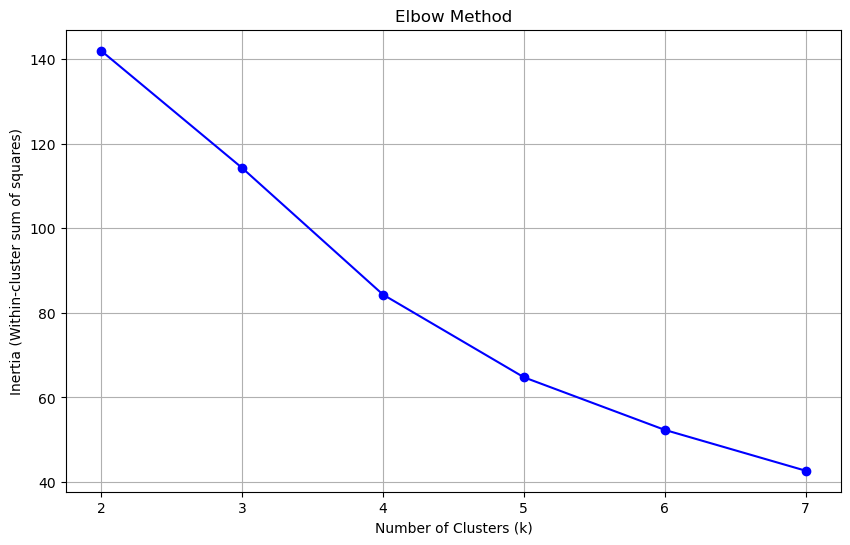

In [11]:
# Define clustering features
cluster_features = ['log_area', 'age', 'protection_intensity', 'iucn_strictness', 'has_mgmt_plan']
FEATURES = cluster_features

# Drop rows with missing values in selected features
ct_clust_df = ct_wdpa_op_gdf.dropna(subset=FEATURES).copy()

# Standardize features
# Define x variables
X = ct_clust_df[FEATURES].values
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters - Elbow method
inertias = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)  

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_range, inertias, 'bo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia (Within-cluster sum of squares)')
ax.set_title('Elbow Method')
ax.grid(True)

print("\n=== CLUSTER EVALUATION ===")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: Inertia={inertia:.0f}")

In [12]:
# Fit final k-means model with k=4
kmeans_final = KMeans(n_clusters=4, random_state=0)
ct_clust_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Create summary of cluster profiles
ct_clust_sum = ct_clust_df.groupby('cluster').agg({
    'REP_M_AREA': ['mean', 'median', 'count'],
    'age': ['mean', 'median'],
    'protection_intensity': 'mean',
    'PRNT_ISO3': lambda x: x.mode()[0] if len(x) > 0 else 'Mixed',
    'GOV_TYPE': lambda x: x.mode()[0] if len(x) > 0 else 'Mixed',
    'IUCN_CAT': lambda x: x.mode()[0] if len(x) > 0 else 'Mixed'
})
ct_clust_sum

REP_M_AREA                          age        protection_intensity  \
                mean      median count       mean median                 mean   
cluster                                                                         
0         498.845503  220.990000     9  28.555556   26.0             0.111111   
1         932.005395  135.174450    36   9.833333    7.0             0.000000   
2          12.931654    0.615787    25  29.440000   31.0             0.960000   
3        1157.468179  693.530000    11  18.454545   24.0             0.454545   

        PRNT_ISO3                                GOV_TYPE IUCN_CAT  
         <lambda>                                <lambda> <lambda>  
cluster                                                             
0             IDN  Federal or national ministry or agency        V  
1             PHL  Federal or national ministry or agency        V  
2             MYS  Federal or national ministry or agency       II  
3             PHL  Federal or national ministry or agency       II

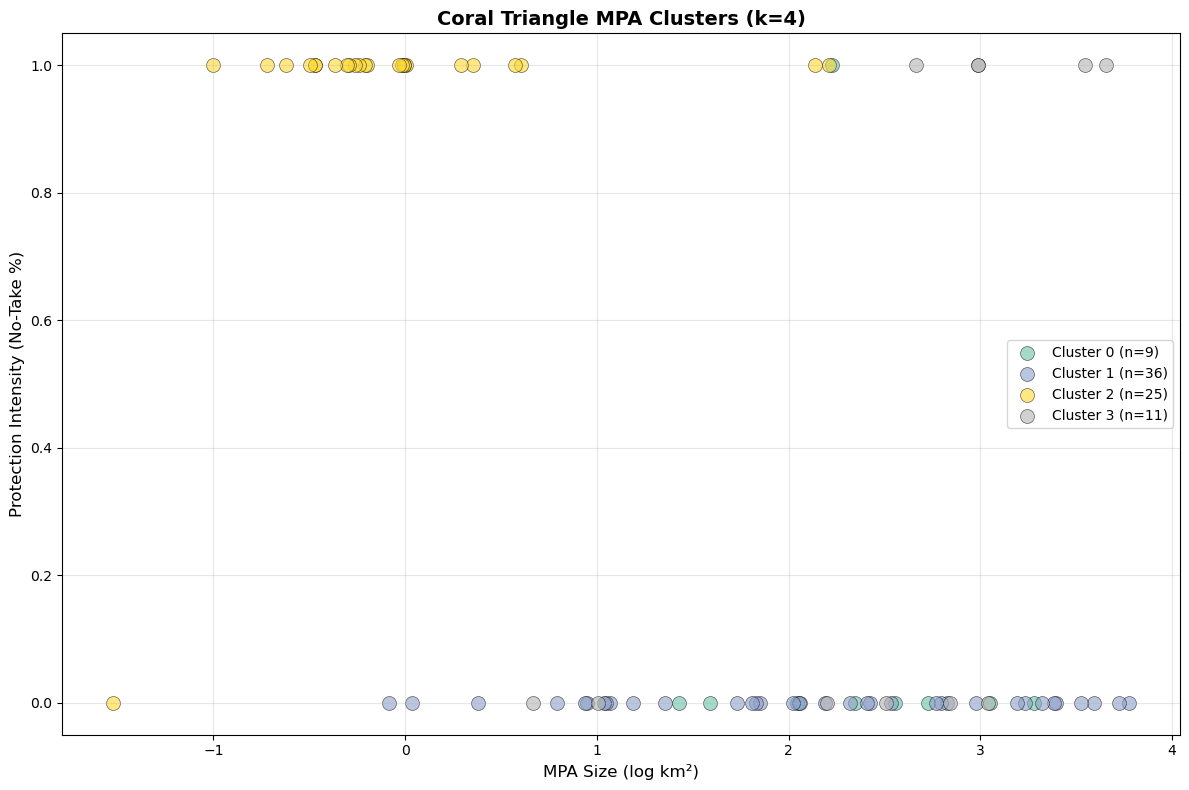

In [13]:
# Create scatter plot
plt.figure(figsize=(12, 8))

# Plot each cluster with different color
colors = plt.cm.Set2(np.linspace(0, 1, 4))
for cluster_id in range(4):
    cluster_data = ct_clust_df[ct_clust_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['log_area'], 
        cluster_data['protection_intensity'],
        c=[colors[cluster_id]], 
        label=f'Cluster {cluster_id} (n={len(cluster_data)})',
        alpha=0.6, 
        s=100,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('MPA Size (log km²)', fontsize=12)
plt.ylabel('Protection Intensity (No-Take %)', fontsize=12)
plt.title(f'Coral Triangle MPA Clusters (k={4})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Prepare cluster export dataset
export_cols = [
    'NAME_ENG', 'PRNT_ISO3', 'REP_M_AREA', 'log_area', 'age',
    'protection_intensity', 'IUCN_CAT', 'GOV_TYPE', 'OWN_TYPE',
    'STATUS', 'has_mgmt_plan', 'cluster'
]

ct_clust_export_df = ct_clust_df[export_cols].copy()
ct_clust_export_df['country_name'] = ct_clust_export_df['PRNT_ISO3'].map(ct)

### Chart 5: Governance Structures of Marine Protected Areas
- Type: Stacked bar chart
- Data sources: WDPA
- Shows: Distribution of governance types across operational MPAs
- Key insight: Who managed marine protection? Is there governance diversity or centralization?
- Purpose: Identify institutional patterns and assess potential for expanding collaborative management

In [15]:
# Aggregate protected area sum and unique count by country and government type
ct_wdpa_gov_df = ct_wdpa_op_gdf.groupby(['PRNT_ISO3', 'GOV_TYPE']).agg({'REP_M_AREA': 'sum', 'SITE_ID': 'nunique'}).reset_index()
# Sum total protected area by country
ct_wdpa_gov_df['total_by_country'] = ct_wdpa_gov_df.groupby('PRNT_ISO3')['REP_M_AREA'].transform('sum')
# Calculate percentage of protected area by government type
ct_wdpa_gov_df['pct_area'] = ct_wdpa_gov_df['REP_M_AREA'] / ct_wdpa_gov_df['total_by_country'] * 100

# Rename column
ct_wdpa_gov_df.rename({'SITE_ID': 'protected_area_count'}, axis=1, inplace=True)

# Map country name
ct_wdpa_gov_df['country_name'] = ct_wdpa_gov_df['PRNT_ISO3'].map(ct)

# Simplify governance labels
gov_labels = {
    'Federal or national ministry or agency': 'National',
    'Sub-national ministry or agency': 'Sub-National',
    'Joint governance': 'Joint',
    'Collaborative governance': 'Collaborative',
    'Indigenous Peoples': 'Indigenous Communities',
    'Local communities': 'Local Communities',
    'Government-delegated management': 'Delegated Management',
    'Not Reported': 'Not Reported'
}
ct_wdpa_gov_df['gov_type_short'] = ct_wdpa_gov_df['GOV_TYPE'].map(gov_labels)
ct_wdpa_gov_df

,PRNT_ISO3,GOV_TYPE,REP_M_AREA,protected_area_count,total_by_country,pct_area,country_name,gov_type_short
0,IDN,Federal or national ministry or agency,6022.883000,7,25205.241900,23.895359,Indonesia,National
1,IDN,Not Reported,3265.140000,3,25205.241900,12.954210,Indonesia,Not Reported
2,IDN,Sub-national ministry or agency,15917.218900,10,25205.241900,63.150431,Indonesia,Sub-National
3,MYS,Federal or national ministry or agency,323.261344,24,10904.151344,2.964571,Malaysia,National
4,MYS,Government-delegated management,463.170000,1,10904.151344,4.247648,Malaysia,Delegated Management
5,MYS,Sub-national ministry or agency,10117.720000,1,10904.151344,92.787780,Malaysia,Sub-National
6,PHL,Federal or national ministry or agency,37691.478011,57,37691.478011,100.000000,Philippines,National
7,PNG,Federal or national ministry or agency,26.940000,1,27.984000,96.269297,Papua New Guinea,National
8,PNG,Indigenous Peoples,1.044000,2,27.984000,3.730703,Papua New Guinea,Indigenous Communities
9,SLB,Collaborative governance,169.090000,1,666.812700,25.357945,Solomon Islands,Collaborative


## Section 6: Data Export

Exports processed datasets to JSON/GeoJSON format for web visualizations

All files use consistent naming: chart[N]_description.format

In [17]:
# Save created geo-dataframes as GeoJSON to Github repo
geodatasets = {
    'chart1_ct_choro': ct_choro_gdf
}
for name, gdf in geodatasets.items():
    filepath = f'{up_path}{name}.geojson'
    gdf.to_file(filepath, driver='GeoJSON')

# Save created dataframes as JSON to Github repo
datasets = {
    'chart2_cumulative_areas': ct_cum_df,
    'chart7_area_governance': ct_wdpa_gov_df,
    'chart2_regression': regression_df,
    'chart2_2030targets': targets_30,
    'chart6_cluster_analysis': ct_clust_export_df
}
for name, df in datasets.items():
    filepath = f'{up_path}{name}.json'
    df.to_json(filepath, orient='records', indent=None)